### Подготовительный этап

Обоснование происходящего будет [тут](https://raw.githubusercontent.com/johanDDC/RiemannianOptimizationTT/3af4e53147cd5a89dd53461d22775641cfddcd6e/partial_evp/evp.pdf).

Если вкратце: хочу работать с операторами вида
\begin{align*}
\mathcal{A} \colon \mathbb{R}^{n_1 \times \ldots \times n_d} \to \mathbb{R}^{m_1 \times \ldots \times m_d}
\end{align*}

Такие операторы задаются тензорами, вида $\mathbf{A} \in
\mathbb{R}^{(m_1 \times n_1) \times \ldots \times (m_d \times n_d)}$, и TT-разложения таких
операторов содержат ядра порядка $4$. TTAX в такое не умеет, он работает только с ядрами
порядка $3$. А мне прям жесть как это нужно. В файлике я расписываю оптимальный способ получить
TT-разложение, которое мне нужно, и оптимальный способ умножить такой оператор на тензор.


In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from numpy import random
import ttax
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def get_operator_from_tt(tt: ttax.base_class.TT):
    operator_cores = [
        jnp.einsum('abi,icd->abcd', tt.tt_cores[i], tt.tt_cores[i + 1])
        for i in range(0, len(tt.tt_cores), 2)
    ]
    return operator_cores

def TT_matmul(operator_cores, tt2 : ttax.base_class.TT):
    cores = [
            jnp.einsum('abic,eig->aebcg', operator_cores[i], tt2.tt_cores[i]).reshape((
                operator_cores[i].shape[0] * tt2.tt_ranks[i], operator_cores[i].shape[1],
                operator_cores[i].shape[3] * tt2.tt_ranks[i + 1]), order="F"
            )
        for i in range(len(tt2.tt_cores))
    ]
    return ttax.base_class.TT(cores)

def transpose_operator(operator_cores):
    cores = [jnp.einsum('aijb->ajib', operator_cores[i]) for i in range(len(operator_cores))]
    return cores

Простой тест: есть оператор $\mathbb{R}^{3\times2} \to \mathbb{R}^{2\times2}$, и случайный
тензор из $\mathbb{R}^{3\times2}$. Мы ожидаем, что результом применение оператора к
тензору будет тензор из $\mathbb{R}^{2\times2}$:

In [59]:
# simple test: we have an operator from R^{3x2} to R^{2x2} and random tensor from R^{3x2}
# we expect, that result of applying operator to tensor will be tensor from R^{2x2}
modes = (2, 3, 2, 2)
TT_op = ttax.random.tensor(jax.random.PRNGKey(42), modes)
TT_el = ttax.random.tensor(jax.random.PRNGKey(42), (3, 2))
print("operator shape is", TT_op.shape)
print("source tensor shape is", TT_el.shape)
print("target tensor shape is", TT_matmul(get_operator_from_tt(TT_op), TT_el).shape)

operator shape is (2, 3, 2, 2)
source tensor shape is (3, 2)
target tensor shape is (2, 2)


### Основной этап

Тестировать будем на симметричных операторах такого вида: если $\mathbf{A}$ — случайный оператор,
тогда оператор $\mathbf{A} + \mathbf{A}^T$ — симметричный.

**Проблема**: оператор для нас, это коллекция TT ядер порядка $4$, от которых ожидается только умение
каким-то образом умножаться на тензор из source пространства. Соответственно, складывать
операторы мы не умеем, поэтому не сможем сделать операцию
$(\mathbf{A} + \mathbf{A}^T)x$. Зато мы сможем сделать $(\mathbf{A}x) + (\mathbf{A}^Tx)$,
так как результатом умножения оператора на тензор является объект класса
ttax.base_class.TT. По этой причине в коде ниже будем представлять операторы, как
функции, принимающие тензор, на который надо умножить оператор.

In [84]:
make_rayleigh = lambda A: lambda x: ttax.flat_inner(x, A(x)) / ttax.flat_inner(x, x)
norm = lambda x: jnp.sqrt(ttax.flat_inner(x, x))
residual = lambda A, x, eig: norm(ttax.orthogonalize(A(x) + (-eig) * x)) / norm(ttax.orthogonalize((-eig) * x))
retraction = lambda T, rk: ttax.orthogonalize(ttax.round(T, max_tt_rank=rk))

def armijo_backtracking(init, grad, rk, mul, beta, func, x):
    alpha = init
    iters = 0
    optimal_x = retraction(x + (-alpha) * grad, rk)
    while func(x) - func(optimal_x) < mul * alpha * norm(grad) ** 2:
        alpha *= beta
        iters += 1
        optimal_x = retraction(x + (-alpha) * grad, rk)
        if iters > 20:
            alpha = 0.1
            optimal_x = retraction(x + (-alpha) * grad, rk)
            break
    return optimal_x

В процессе тестирования возникала проблема: алгоритм на очередной итерации заходил в
Армихо, и больше не выходил оттуда. Чтобы избежать такой ситуации, я немного модифицировал
Армихо: если мы там находимся слишком долго, то назначим небольшую длину шага ручками и
принудительно выйдем. Если мы немного пролетели оптимальный шаг, то придётся вернуться
когда-нибудь на следующей итерации, но по крайней мере алгоритм продолжится.

In [85]:
def riemanGD(A, init, tol, rk, max_iter = None, debug = False):
    rayleigh = make_rayleigh(A)
    rieman_grad = ttax.autodiff.grad(rayleigh)
    x = ttax.orthogonalize(init)
    residuals = [residual(A, x, rayleigh(x))]
    iters = 0
    if debug == True:
        print("№\tresidual")
    while residual(A, x, rayleigh(x)) > tol:
        rieman_x = ttax.orthogonalize(rieman_grad(x))
        x = armijo_backtracking(2, rieman_x, rk, 1E-4, 0.8, rayleigh, x)
        iters += 1
        residuals.append(residual(A, x, rayleigh(x)))
        if debug == True:
            print("{}\t{}".format(iters, residual(A, x, rayleigh(x))))
        if (max_iter is not None and iters >= max_iter) or\
            (len(residuals) > 2 and residuals[-2] == residuals[-1]):
            break

    return x, residuals

In [110]:
core1 = np.zeros((1,4,4))
core1[0,0,0] = core1[0,2,2] = core1[0,1,1] = core1[0, 3, 3] = 1
core2 = np.zeros((4,4,4))
core2[0,0,0] = core2[1,1,1] = core2[2,2,2] = core2[3,3,3] =  1
core3 = core2.copy()
core4 = np.zeros((4,4,1))
core4[0,0,0] = core4[1,1,0] = core4[2,2,0] = core4[3,3,0] =  1
I3 = jnp.array(core2)
eye = ttax.base_class.TT(
    [core1,core2, core3, core4]
)
rank = 2
t = ttax.random.tensor(jax.random.PRNGKey(42),(4,4), tt_rank=rank)
print("Toy test --- identity tensor")
v, rs = riemanGD(lambda x: TT_matmul(get_operator_from_tt(eye), x), t, 4E-4, rank, 40, True)

Toy test --- identity tensor
№	residual
1	2.3915789127349854
2	2.665376901626587
3	2.954705238342285
4	3.2609376907348633
5	3.5858283042907715
6	3.931366205215454
7	4.299698352813721
8	4.6930928230285645
9	5.1139326095581055
10	5.56471061706543
11	6.048038482666016
12	6.566659450531006
13	7.12346076965332
14	7.7214884757995605
15	8.363956451416016
16	9.054275512695312
17	9.796035766601562
18	10.593056678771973
19	11.449399948120117
20	12.369338989257812
21	13.357447624206543
22	14.418546676635742
23	15.557775497436523
24	16.78053092956543
25	18.092632293701172
26	19.500144958496094
27	21.009571075439453
28	22.627744674682617
29	24.36191749572754
30	26.219797134399414
31	28.2094783782959
32	30.339601516723633
33	32.619144439697266
34	35.05783462524414
35	37.66579818725586
36	40.453712463378906
37	43.43285369873047
38	46.61518478393555
39	50.01340103149414
40	53.64066696166992


In [111]:
print(make_rayleigh(lambda x: TT_matmul(get_operator_from_tt(eye), x))(v))

0.00034742468


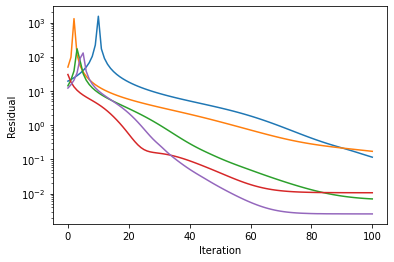

In [99]:
n = 5
graphs = []
rank = 5
for i in range(n):
    modes_op = [rank] * 8
    modes_t = [rank] * 4
    A = ttax.random.tensor(jax.random.PRNGKey(random.randint(1, 100)), modes_op)
    A_op = get_operator_from_tt(A)
    AT = transpose_operator(A_op)
    sym = lambda x: TT_matmul(A_op, x) + TT_matmul(AT, x)
    t = ttax.random.tensor(jax.random.PRNGKey(42), modes_t, tt_rank=rank)
    v, rs = riemanGD(sym, t, 4E-4, rank, 100)
    graphs.append(plt.plot(rs))

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

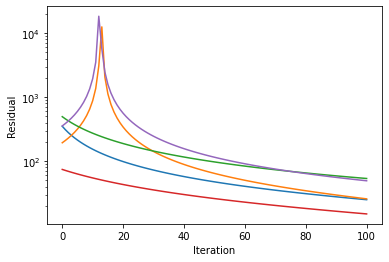

In [88]:
n = 5
graphs = []
rank = 10
for i in range(n):
    modes_op = [rank] * 8
    modes_t = [rank] * 4
    A = ttax.random.tensor(jax.random.PRNGKey(random.randint(1, 100)), modes_op)
    A_op = get_operator_from_tt(A)
    AT = transpose_operator(A_op)
    sym = lambda x: TT_matmul(A_op, x) + TT_matmul(AT, x)
    t = ttax.random.tensor(jax.random.PRNGKey(42), modes_t, tt_rank=rank)
    v, rs = riemanGD(sym, t, 4E-4, rank, 100)
    graphs.append(plt.plot(rs))
    
plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)

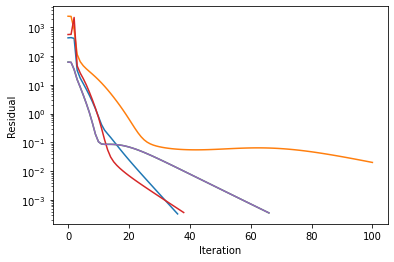

In [90]:
n = 5
graphs = []
rank = 20
for i in range(n):
    modes_op = [rank] * 8
    modes_t = [rank] * 4
    A = ttax.random.tensor(jax.random.PRNGKey(random.randint(1, 100)), modes_op)
    A_op = get_operator_from_tt(A)
    AT = transpose_operator(A_op)
    sym = lambda x: TT_matmul(A_op, x) + TT_matmul(AT, x)
    t = ttax.random.tensor(jax.random.PRNGKey(42), modes_t)
    v, rs = riemanGD(sym, t, 4E-4, rank, 100)
    graphs.append(plt.plot(rs))

plt.xlabel("Iteration")
plt.ylabel("Residual")
plt.semilogy()
plt.show(graphs)